In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import math
import random
from sklearn import preprocessing

In [2]:
data = pd.read_csv('Darwin_100y_features.csv',header=0)

In [3]:
data

,date,month,mon_rain_sum,max_temp_mean,min_temp_mean,radiation_mean,rh_tmax_mean,rh_tmin_mean,SOI,NINO 12,NINO 3,NINO 3.4,NINO 4,DMI,PDO
0,1921/1/1,1,336.0,32.093548,24.774194,16.603226,65.348387,98.777419,10.8,-0.442339,0.303360,0.490091,-0.057400,-0.119109,-0.66
1,1921/2/1,2,346.3,31.550000,24.546429,15.132143,67.785714,99.675000,6.7,-0.510237,-0.229834,-0.499174,-0.510563,0.010900,-0.61
2,1921/3/1,3,329.6,31.493548,24.448387,16.109677,67.867742,99.890323,8.9,-0.558844,-1.094380,-1.372060,-0.943420,0.079200,-0.01
3,1921/4/1,4,36.3,33.103333,23.326667,19.400000,52.250000,91.966667,-7.1,-0.939302,-0.593195,-0.481306,-0.259726,0.001330,-0.93
4,1921/5/1,5,0.6,32.680645,22.706452,18.496774,50.680645,90.167742,2.1,-0.750797,-0.841282,-0.841772,-0.678158,0.164967,-0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2020/8/1,8,0.0,32.590323,20.990323,22.509677,43.145161,81.270968,9.8,-0.536390,-0.428913,-0.341616,0.092700,0.110595,-0.28
1196,2020/9/1,9,87.8,33.946667,23.656667,22.883333,49.030000,87.813333,10.5,-0.970116,-0.822868,-0.607735,-0.076900,0.185042,-0.70
1197,2020/10/1,10,167.8,33.577419,25.258065,23.445161,53.535484,86.132258,4.2,-1.037680,-1.005360,-1.148310,-0.499672,0.437923,-0.69
1198,2020/11/1,11,89.0,34.990000,25.776667,22.636667,51.293333,86.010000,9.2,-0.890734,-0.898487,-0.960775,-0.335106,0.276562,-1.12


In [4]:
global data_np 
data_np = data.to_numpy()[:,2:]

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
data_np_scale = min_max_scaler.fit_transform(data_np)
original_rain_data = data_np[:,0]
global max_rain
max_rain = np.max(original_rain_data)
rain_data = data_np_scale[:,0]

In [6]:
global feat_num,use_len
feat_num = data_np.shape[1]
use_len = 12
pred_len = 12
hidden_dim = 128
batch_size = 64

In [7]:
def create_index_set(rain_data,data_np,use_len,pred_len): 
    
    sample_size = len(rain_data)-(use_len + pred_len - 1)
    
    X_sample = np.zeros((sample_size,use_len,data_np.shape[1]))
    Y_sample = np.zeros((sample_size,pred_len))
    
    for i in range(use_len,len(rain_data)-pred_len+1):  
        Y_sample[i-use_len]= rain_data[i:i+pred_len]
        X_sample[i-use_len]= data_np[i-use_len:i,:]
            
    X_sample = X_sample.reshape(len(X_sample),use_len,data_np.shape[1])
    Y_sample = Y_sample.reshape(len(Y_sample),pred_len,1)

    return X_sample,Y_sample

In [8]:
X_sample,Y_sample = create_index_set(original_rain_data,data_np_scale,use_len,pred_len)

In [9]:
X_sample.shape

(1177, 12, 13)

In [10]:
X_tr,X_1fold,Y_tr,Y_1fold = train_test_split(X_sample,Y_sample,test_size=392,shuffle = True)
X_2fold,X_3fold,Y_2fold,Y_3fold = train_test_split(X_tr,Y_tr,test_size=392,shuffle = True)

X1fold_tensor=torch.from_numpy(X_1fold)
Y1fold_tensor=torch.from_numpy(Y_1fold)

X2fold_tensor=torch.from_numpy(X_2fold)
Y2fold_tensor=torch.from_numpy(Y_2fold)

X3fold_tensor=torch.from_numpy(X_3fold)
Y3fold_tensor=torch.from_numpy(Y_3fold)

In [11]:
class RainTrainDataset(Dataset):
    
    def __init__(self,X_train,Y_train):

        self.input = torch.from_numpy(X_train) 
        self.output = torch.from_numpy(Y_train)  
    
    def __getitem__(self, index):
        return self.input[index], self.output[index]

    def __len__(self):
        return len(self.input)
    
class encoder_gru(nn.Module):
    
    def __init__(self, input_size, hidden_size,num_layers):
        
        super(encoder_gru, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
        self.gru = torch.nn.GRU(input_size = self.input_size,hidden_size = self.hidden_size,\
                                num_layers=self.num_layers,batch_first=True)
        
    def forward(self, input):
        
        self.batch_size = input.shape[0]
        hidden_0 = torch.zeros(self.num_layers,self.batch_size,self.hidden_size)
        output1, hidden1 = self.gru(input, hidden_0)
        
        return output1 

class Attention(nn.Module):
    
    def __init__(self, hidden_size):
        
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)

    def forward(self, hidden, encoder_outputs):

        this_batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1).transpose(0,1)    
        attn_energies = self.score(H,encoder_outputs) # compute attention score
        return F.softmax(attn_energies,dim = 1).unsqueeze(1)  # normalize with softmax

    def score(self, hidden, encoder_outputs):
        
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2))) 
        energy = energy.transpose(2,1) 
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) 
        energy = torch.bmm(v,energy) 
        
        return energy.squeeze(1)

class decoder_gru_cell(nn.Module):
    
    def __init__(self, hidden_size, output_size, n_layers):
        
        super(decoder_gru_cell, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Define layers
        
        self.attn = Attention(hidden_size = self.hidden_size)
        self.gru = nn.GRU(hidden_size+1, hidden_size, n_layers, batch_first= True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, current_input, last_hidden, encoder_outputs):
        
        # Calculate attention weights and apply to encoder outputs
        
        current_input = current_input.unsqueeze(0)   
        attn_weights = self.attn(last_hidden, encoder_outputs)  
        context = attn_weights.bmm(encoder_outputs)  
        context = context.transpose(0, 1)  
        rnn_input = torch.cat((current_input, context), 2)   
        rnn_input = rnn_input.transpose(0,1)        
        output, hidden = self.gru(rnn_input, last_hidden)    
        output = output.squeeze(1) 
        output = torch.relu(self.out(output)) 
        
        return output,hidden

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder_cell,pre_len,hidden_size, decoder_layers):
        
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder_cell = decoder_cell
        self.pre_len = pre_len
        self.hidden_size = hidden_size   #decoder 的hidden size
        self.decoder_layers = decoder_layers  #decoder 的num_layers
        
    def forward(self,input):
        
        batch_size = input.size(0)
        use_len = input.size(1)
        feat_num = input.size(2)
        encoder_outputs = self.encoder(input)
        
        outputs = torch.zeros(self.pre_len,batch_size,1)
        
        current_input = input[:,-1,-1].reshape(batch_size,1)  # current_input: [B,1]
        last_hidden = torch.zeros(self.decoder_layers,batch_size,self.hidden_size)
        
        for i in range(self.pre_len):
        
            output,hidden = self.decoder_cell(current_input, last_hidden, encoder_outputs)
            current_input = output
            last_hidden = hidden
            outputs[i] = output
            
        outputs = outputs.transpose(0,1) #outputs:(B,pre_len,1)
        outputs = outputs*max_rain
        
        return outputs

In [12]:
def evaluate_model(set_tensor,tar_tensor,model,criterion):
    model.eval()
    output = model(set_tensor.float())
    res_output = output.reshape(-1,1)
    target=tar_tensor.reshape(-1,1)   
    MSE = criterion(res_output, target)
    R2= r2_score(target.numpy(),res_output.numpy())
    return tar_tensor.numpy(),output.numpy(),MSE.item(),R2

Train the 1st fold,X_1fold serves as the test set

In [13]:
encoder_1 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1)
decoder_cell_1 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1)
Seq2Seq_model_1 = Seq2Seq(encoder_1, decoder_cell_1,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)

X_train_1  = np.concatenate((X_2fold,X_3fold),axis = 0)
Y_train_1 = np.concatenate((Y_2fold,Y_3fold),axis = 0)
X_train_1_tensor = torch.from_numpy(X_train_1)
Y_train_1_tensor = torch.from_numpy(Y_train_1)

trainset_1 = RainTrainDataset(X_train_1, Y_train_1)
trainloader_1 = DataLoader(trainset_1, batch_size=batch_size, shuffle=True)
criterion_1 = torch.nn.MSELoss()  
optimizer_1 = torch.optim.Adam(Seq2Seq_model_1.parameters(), lr=0.001,weight_decay =0) #0.0001)
scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_1,T_max = 32,eta_min = 0, last_epoch=-1)

 1 epoch ... 
best test R2 at this time -9.709410919134243e-05
 2 epoch ... 
best test R2 at this time -5.042077146977242e-05
 3 epoch ... 
best test R2 at this time 0.00035859082239575457
 4 epoch ... 
best test R2 at this time 0.0016200958429882784
 5 epoch ... 
best test R2 at this time 0.0019126074660408277
 6 epoch ... 
best test R2 at this time 0.0023996219691881926
 7 epoch ... 
best test R2 at this time 0.003115972418988977
 8 epoch ... 
 9 epoch ... 
best test R2 at this time 0.006562216624967254
 10 epoch ... 
best test R2 at this time 0.007039396151970023
 11 epoch ... 
best test R2 at this time 0.007320758282655548
 12 epoch ... 
best test R2 at this time 0.010045551390868268
 13 epoch ... 
best test R2 at this time 0.020346548825233457
 14 epoch ... 
best test R2 at this time 0.04271861320032655
 15 epoch ... 
best test R2 at this time 0.07177735733087476
 16 epoch ... 
 17 epoch ... 
best test R2 at this time 0.1692538929055415
 18 epoch ... 
best test R2 at this time 0.3

 313 epoch ... 
 314 epoch ... 
 315 epoch ... 
 316 epoch ... 
best test R2 at this time 0.6933018570937937
 317 epoch ... 
 318 epoch ... 
 319 epoch ... 
best test R2 at this time 0.6958856760727317
 320 epoch ... 
 321 epoch ... 
best test R2 at this time 0.6964966288291603
 322 epoch ... 
 323 epoch ... 
 324 epoch ... 
 325 epoch ... 
 326 epoch ... 
 327 epoch ... 
 328 epoch ... 
 329 epoch ... 
 330 epoch ... 
 331 epoch ... 
best test R2 at this time 0.6968078576767629
 332 epoch ... 
 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
best test R2 at this time 0.700989383185106
 336 epoch ... 
 337 epoch ... 
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
 341 epoch ... 
 342 epoch ... 
 343 epoch ... 
 344 epoch ... 
 345 epoch ... 
 346 epoch ... 
 347 epoch ... 
 348 epoch ... 
 349 epoch ... 
 350 epoch ... 
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
best test R2 at this time 0.7019479454092988
 355 epoch ... 
best test R2 at this time 0.703384819781339

 666 epoch ... 
 667 epoch ... 
 668 epoch ... 
 669 epoch ... 
best test R2 at this time 0.8006656465306982
 670 epoch ... 
 671 epoch ... 
 672 epoch ... 
 673 epoch ... 
 674 epoch ... 
 675 epoch ... 
 676 epoch ... 
 677 epoch ... 
 678 epoch ... 
 679 epoch ... 
 680 epoch ... 
 681 epoch ... 
 682 epoch ... 
 683 epoch ... 
 684 epoch ... 
 685 epoch ... 
best test R2 at this time 0.8030755538872283
 686 epoch ... 
 687 epoch ... 
 688 epoch ... 
 689 epoch ... 
 690 epoch ... 
 691 epoch ... 
 692 epoch ... 
 693 epoch ... 
 694 epoch ... 
 695 epoch ... 
best test R2 at this time 0.8043970008586432
 696 epoch ... 
 697 epoch ... 
 698 epoch ... 
 699 epoch ... 
 700 epoch ... 
 701 epoch ... 
 702 epoch ... 
 703 epoch ... 
best test R2 at this time 0.8067935237299046
 704 epoch ... 
 705 epoch ... 
 706 epoch ... 
 707 epoch ... 
 708 epoch ... 
 709 epoch ... 
 710 epoch ... 
 711 epoch ... 
 712 epoch ... 
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
 716 epoch ... 
 717

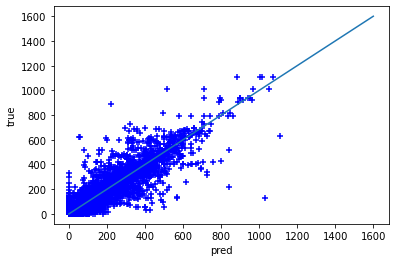

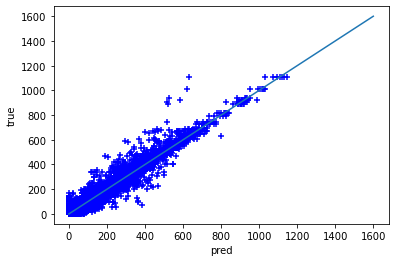

In [15]:

N_EPOCHS_1 = 1000

train_MSEloss_1=[]
test_MSEloss_1=[]

best_test_loss_1 = 1000000

for epoch in range(1, N_EPOCHS_1+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_1.train()
    for i, (hist, target) in enumerate(trainloader_1, 1):   
        hist = hist.float()
        output = Seq2Seq_model_1(hist)
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1)
        loss = criterion_1(output, target)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
        scheduler_1.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_1_tensor,Y_train_1_tensor,Seq2Seq_model_1,criterion_1)
        train_MSEloss_1.append(train_MSE)
      
        _,_,test_MSE,test_R2 = evaluate_model(X1fold_tensor,Y1fold_tensor,Seq2Seq_model_1,criterion_1)
        test_MSEloss_1.append(test_MSE)

        if test_MSE < best_test_loss_1:
            best_test_loss_1 = test_MSE
            torch.save(Seq2Seq_model_1.state_dict(),'Prediction\best_model_1fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_1fold = Seq2Seq(encoder_1, decoder_cell_1,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_1fold.load_state_dict(torch.load('Prediction\best_model_1fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_1fold,test_pred_1fold,test_MSE_1fold,test_R2_1fold = evaluate_model(X1fold_tensor,Y1fold_tensor,\
                                                                                  best_Seq2Seq_model_1fold,criterion_1)
    
    print(f'Test 1 fold MSE: {test_MSE_1fold}')
    print(f'Test 1 fold R2: {test_R2_1fold}')
    plt.figure(3)
    plt.scatter(test_pred_1fold,test_true_1fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_1fold,train_pred_1fold,train_MSE_1fold,train_R2_1fold = evaluate_model(X_train_1_tensor,Y_train_1_tensor,\
                                                                                      best_Seq2Seq_model_1fold,criterion_1)
    
    print(f'train 1 fold MSE: {train_MSE_1fold}')
    print(f'train 1 fold R2: {train_R2_1fold}')
    plt.figure(5)
    plt.scatter(train_pred_1fold,train_true_1fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [16]:
SHAP_VALUE = np.zeros([pred_len,len(X_sample),use_len,feat_num])

In [17]:
import shap

allset_tensor = torch.from_numpy(X_sample)
background = allset_tensor.float()

e_1 = shap.GradientExplainer(best_Seq2Seq_model_1fold,background)
shap_values_1fold = e_1.shap_values(X1fold_tensor.float())
shap_values_1fold = np.array(shap_values_1fold)  

np.save('Explanation\shap_values_1fold.npy',shap_values_1fold)

# scale the shap values
for i in range(shap_values_1fold.shape[0]):   
    for j in range(shap_values_1fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_1fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_1fold[i,j]

Train the 2nd fold,X_2fold serves as the test set

In [20]:
encoder_2 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1)
decoder_cell_2 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1)
Seq2Seq_model_2 = Seq2Seq(encoder_2, decoder_cell_2,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)

X_train_2  = np.concatenate((X_1fold,X_3fold),axis = 0)
Y_train_2 = np.concatenate((Y_1fold,Y_3fold),axis = 0)
X_train_2_tensor = torch.from_numpy(X_train_2)
Y_train_2_tensor = torch.from_numpy(Y_train_2)

trainset_2 = RainTrainDataset(X_train_2, Y_train_2)
trainloader_2 = DataLoader(trainset_2, batch_size=batch_size, shuffle=True)
criterion_2 = torch.nn.MSELoss()  
optimizer_2 = torch.optim.Adam(Seq2Seq_model_2.parameters(), lr=0.001,weight_decay =0) #0.0001)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_2,T_max = 32,eta_min = 0, last_epoch=-1)


 1 epoch ... 
best test R2 at this time 0.003898866011505353
 2 epoch ... 
 3 epoch ... 
 4 epoch ... 
 5 epoch ... 
best test R2 at this time 0.005417423970912938
 6 epoch ... 
 7 epoch ... 
 8 epoch ... 
best test R2 at this time 0.012319351974653059
 9 epoch ... 
best test R2 at this time 0.030681504180387065
 10 epoch ... 
best test R2 at this time 0.07559503419427793
 11 epoch ... 
best test R2 at this time 0.08418933394423866
 12 epoch ... 
best test R2 at this time 0.22110486536875273
 13 epoch ... 
best test R2 at this time 0.42497694604719805
 14 epoch ... 
best test R2 at this time 0.5622063533876469
 15 epoch ... 
best test R2 at this time 0.5853160392738201
 16 epoch ... 
 17 epoch ... 
best test R2 at this time 0.5856452208741529
 18 epoch ... 
best test R2 at this time 0.5988010908315595
 19 epoch ... 
 20 epoch ... 
best test R2 at this time 0.6237825803041871
 21 epoch ... 
 22 epoch ... 
 23 epoch ... 
 24 epoch ... 
best test R2 at this time 0.6278623727519616
 25 epo

 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
best test R2 at this time 0.7180090614711405
 336 epoch ... 
 337 epoch ... 
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
best test R2 at this time 0.7180942781396158
 341 epoch ... 
best test R2 at this time 0.7197524637547918
 342 epoch ... 
 343 epoch ... 
 344 epoch ... 
 345 epoch ... 
best test R2 at this time 0.722819062156018
 346 epoch ... 
best test R2 at this time 0.7238587609690368
 347 epoch ... 
 348 epoch ... 
 349 epoch ... 
 350 epoch ... 
best test R2 at this time 0.7258175590270832
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
 355 epoch ... 
best test R2 at this time 0.7279503085933434
 356 epoch ... 
 357 epoch ... 
 358 epoch ... 
 359 epoch ... 
 360 epoch ... 
best test R2 at this time 0.7284502239912756
 361 epoch ... 
 362 epoch ... 
 363 epoch ... 
 364 epoch ... 
 365 epoch ... 
best test R2 at this time 0.7323807381618697
 366 epoch ... 
best test R2 at this time 0.7339036098393585
 367 ep

 669 epoch ... 
 670 epoch ... 
 671 epoch ... 
 672 epoch ... 
 673 epoch ... 
 674 epoch ... 
 675 epoch ... 
best test R2 at this time 0.839676499670763
 676 epoch ... 
 677 epoch ... 
 678 epoch ... 
 679 epoch ... 
 680 epoch ... 
 681 epoch ... 
 682 epoch ... 
 683 epoch ... 
 684 epoch ... 
 685 epoch ... 
 686 epoch ... 
 687 epoch ... 
 688 epoch ... 
 689 epoch ... 
 690 epoch ... 
best test R2 at this time 0.8409943719747273
 691 epoch ... 
 692 epoch ... 
 693 epoch ... 
 694 epoch ... 
 695 epoch ... 
 696 epoch ... 
 697 epoch ... 
 698 epoch ... 
 699 epoch ... 
 700 epoch ... 
best test R2 at this time 0.843109981497888
 701 epoch ... 
 702 epoch ... 
 703 epoch ... 
 704 epoch ... 
best test R2 at this time 0.8432541172873095
 705 epoch ... 
best test R2 at this time 0.8452318038240321
 706 epoch ... 
 707 epoch ... 
 708 epoch ... 
 709 epoch ... 
 710 epoch ... 
 711 epoch ... 
 712 epoch ... 
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
 716 epoch ... 
 717 epoc

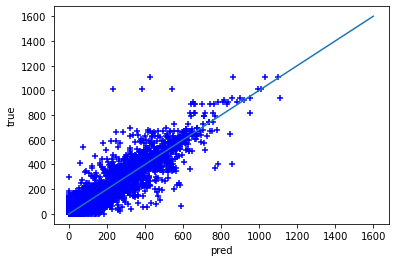

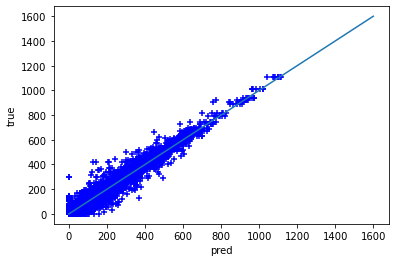

In [22]:

N_EPOCHS_2 = 1000

train_MSEloss_2=[]
test_MSEloss_2=[]

best_test_loss_2 = 1000000

for epoch in range(1, N_EPOCHS_2+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_2.train()
    for i, (hist, target) in enumerate(trainloader_2, 1):   
        hist = hist.float()
        output = Seq2Seq_model_2(hist) 
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1)
        loss = criterion_2(output, target)
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()
        scheduler_2.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_2_tensor,Y_train_2_tensor,Seq2Seq_model_2,criterion_2)
        train_MSEloss_2.append(train_MSE)
        
        _,_,test_MSE,test_R2 = evaluate_model(X2fold_tensor,Y2fold_tensor,Seq2Seq_model_2,criterion_2)
        test_MSEloss_2.append(test_MSE)

        if test_MSE < best_test_loss_2:
            best_test_loss_2 = test_MSE
            torch.save(Seq2Seq_model_2.state_dict(),'Prediction\best_model_2fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_2fold = Seq2Seq(encoder_2, decoder_cell_2,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_2fold.load_state_dict(torch.load('Prediction\best_model_2fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_2fold,test_pred_2fold,test_MSE_2fold,test_R2_2fold = evaluate_model(X2fold_tensor,Y2fold_tensor,\
                                                                                  best_Seq2Seq_model_2fold,criterion_2)
    
    print(f'Test 2 fold MSE: {test_MSE_2fold}')
    print(f'Test 2 fold R2: {test_R2_2fold}')
    plt.figure(3)
    plt.scatter(test_pred_2fold,test_true_2fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_2fold,train_pred_2fold,train_MSE_2fold,train_R2_2fold = evaluate_model(X_train_2_tensor,Y_train_2_tensor,\
                                                                                      best_Seq2Seq_model_2fold,criterion_2)
    
    print(f'train 2 fold MSE: {train_MSE_2fold}')
    print(f'train 2 fold R2: {train_R2_2fold}')
    plt.figure(5)
    plt.scatter(train_pred_2fold,train_true_2fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [23]:
e_2 = shap.GradientExplainer(best_Seq2Seq_model_2fold,background)
shap_values_2fold = e_2.shap_values(X2fold_tensor.float())
shap_values_2fold = np.array(shap_values_2fold)  

np.save('Explanation\shap_values_2fold.npy',shap_values_2fold)

# scale the shap values
for i in range(shap_values_2fold.shape[0]):   
    for j in range(shap_values_2fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_2fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_2fold[i,j]

Train the 3rd fold,X_3fold serves as the test set

In [24]:
encoder_3 = encoder_gru(input_size=feat_num, hidden_size=hidden_dim,num_layers=1)
decoder_cell_3 = decoder_gru_cell(hidden_size=hidden_dim, output_size=1, n_layers=1)
Seq2Seq_model_3 = Seq2Seq(encoder_3, decoder_cell_3,pre_len=pred_len,hidden_size = hidden_dim, decoder_layers = 1)

X_train_3  = np.concatenate((X_1fold,X_2fold),axis = 0)
Y_train_3 = np.concatenate((Y_1fold,Y_2fold),axis = 0)
X_train_3_tensor = torch.from_numpy(X_train_3)
Y_train_3_tensor = torch.from_numpy(Y_train_3)

trainset_3 = RainTrainDataset(X_train_3, Y_train_3)
trainloader_3 = DataLoader(trainset_3, batch_size=batch_size, shuffle=True)
criterion_3 = torch.nn.MSELoss() 
optimizer_3 = torch.optim.Adam(Seq2Seq_model_3.parameters(), lr=0.001,weight_decay =0) #0.0001)
scheduler_3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_3,T_max = 32,eta_min = 0, last_epoch=-1)


 1 epoch ... 
best test R2 at this time -0.005799193229017341
 2 epoch ... 
best test R2 at this time -0.0028400233615488713
 3 epoch ... 
best test R2 at this time -0.00027079533813600953
 4 epoch ... 
 5 epoch ... 
best test R2 at this time 0.0020905918473520524
 6 epoch ... 
best test R2 at this time 0.002188720273572531
 7 epoch ... 
 8 epoch ... 
best test R2 at this time 0.0051097568304353524
 9 epoch ... 
best test R2 at this time 0.007616836233912516
 10 epoch ... 
best test R2 at this time 0.015188719600838119
 11 epoch ... 
best test R2 at this time 0.01640581375180572
 12 epoch ... 
best test R2 at this time 0.03316189292388905
 13 epoch ... 
best test R2 at this time 0.09563010896695012
 14 epoch ... 
best test R2 at this time 0.22070123513596318
 15 epoch ... 
best test R2 at this time 0.35165074592692447
 16 epoch ... 
best test R2 at this time 0.3637400834816442
 17 epoch ... 
best test R2 at this time 0.494810193341907
 18 epoch ... 
best test R2 at this time 0.60046678

 333 epoch ... 
 334 epoch ... 
 335 epoch ... 
best test R2 at this time 0.7081436428749478
 336 epoch ... 
 337 epoch ... 
 338 epoch ... 
 339 epoch ... 
 340 epoch ... 
best test R2 at this time 0.709928727077423
 341 epoch ... 
 342 epoch ... 
 343 epoch ... 
 344 epoch ... 
 345 epoch ... 
 346 epoch ... 
best test R2 at this time 0.7143932412966453
 347 epoch ... 
 348 epoch ... 
 349 epoch ... 
 350 epoch ... 
 351 epoch ... 
 352 epoch ... 
 353 epoch ... 
 354 epoch ... 
 355 epoch ... 
 356 epoch ... 
 357 epoch ... 
 358 epoch ... 
 359 epoch ... 
 360 epoch ... 
best test R2 at this time 0.7151904064666681
 361 epoch ... 
 362 epoch ... 
 363 epoch ... 
 364 epoch ... 
 365 epoch ... 
 366 epoch ... 
 367 epoch ... 
 368 epoch ... 
 369 epoch ... 
 370 epoch ... 
 371 epoch ... 
 372 epoch ... 
 373 epoch ... 
 374 epoch ... 
 375 epoch ... 
 376 epoch ... 
 377 epoch ... 
 378 epoch ... 
 379 epoch ... 
best test R2 at this time 0.7204918891100305
 380 epoch ... 
best tes

best test R2 at this time 0.8002552422607726
 711 epoch ... 
 712 epoch ... 
 713 epoch ... 
 714 epoch ... 
 715 epoch ... 
best test R2 at this time 0.8019360219291989
 716 epoch ... 
 717 epoch ... 
 718 epoch ... 
 719 epoch ... 
 720 epoch ... 
best test R2 at this time 0.8035779536742376
 721 epoch ... 
 722 epoch ... 
 723 epoch ... 
 724 epoch ... 
 725 epoch ... 
 726 epoch ... 
 727 epoch ... 
 728 epoch ... 
 729 epoch ... 
best test R2 at this time 0.8055130902190988
 730 epoch ... 
 731 epoch ... 
 732 epoch ... 
 733 epoch ... 
 734 epoch ... 
 735 epoch ... 
 736 epoch ... 
 737 epoch ... 
 738 epoch ... 
 739 epoch ... 
best test R2 at this time 0.8098038706685751
 740 epoch ... 
 741 epoch ... 
 742 epoch ... 
 743 epoch ... 
 744 epoch ... 
 745 epoch ... 
 746 epoch ... 
 747 epoch ... 
 748 epoch ... 
 749 epoch ... 
 750 epoch ... 
 751 epoch ... 
 752 epoch ... 
 753 epoch ... 
 754 epoch ... 
 755 epoch ... 
 756 epoch ... 
 757 epoch ... 
 758 epoch ... 
 759 ep

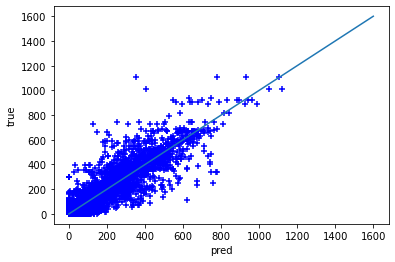

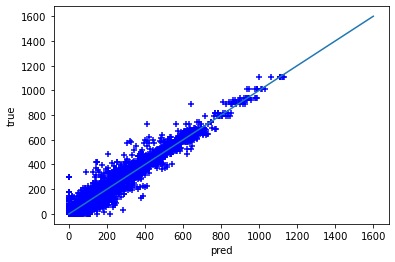

In [26]:

N_EPOCHS_3 = 1000

train_MSEloss_3=[]
test_MSEloss_3=[]

best_test_loss_3 = 1000000

for epoch in range(1, N_EPOCHS_3+1):
    
    print(" %d epoch ... " % epoch)
    Seq2Seq_model_3.train()
    for i, (hist, target) in enumerate(trainloader_3, 1):   
        hist = hist.float()
        output = Seq2Seq_model_3(hist) 
        output= output.reshape(-1,1)
        target=target.float().reshape(-1,1)
        loss = criterion_3(output, target)
        optimizer_3.zero_grad()
        loss.backward()
        optimizer_3.step()
        scheduler_3.step()
        
    with torch.no_grad():
        _,_,train_MSE,_ = evaluate_model(X_train_3_tensor,Y_train_3_tensor,Seq2Seq_model_3,criterion_3)
        train_MSEloss_3.append(train_MSE)
        
        _,_,test_MSE,test_R2 = evaluate_model(X3fold_tensor,Y3fold_tensor,Seq2Seq_model_3,criterion_3)
        test_MSEloss_3.append(test_MSE)

        if test_MSE < best_test_loss_3:
            best_test_loss_3 = test_MSE
            torch.save(Seq2Seq_model_3.state_dict(),'Prediction\best_model_3fold.pth') 
            print('best test R2 at this time',test_R2)

best_Seq2Seq_model_3fold = Seq2Seq(encoder_3, decoder_cell_3,pre_len=12,hidden_size = 128, decoder_layers = 1)
best_Seq2Seq_model_3fold.load_state_dict(torch.load('Prediction\best_model_3fold.pth'))

with torch.no_grad():  
    
    print("testing best model……")
    
    test_true_3fold,test_pred_3fold,test_MSE_3fold,test_R2_3fold = evaluate_model(X3fold_tensor,Y3fold_tensor,\
                                                                                  best_Seq2Seq_model_3fold,criterion_3)
    
    print(f'Test 3 fold MSE: {test_MSE_3fold}')
    print(f'Test 3 fold R2: {test_R2_3fold}')
    plt.figure(3)
    plt.scatter(test_pred_3fold,test_true_3fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')
    

    train_true_3fold,train_pred_3fold,train_MSE_3fold,train_R2_3fold = evaluate_model(X_train_3_tensor,Y_train_3_tensor,\
                                                                                      best_Seq2Seq_model_3fold,criterion_3)
    
    print(f'train 3 fold MSE: {train_MSE_3fold}')
    print(f'train 3 fold R2: {train_R2_3fold}')
    plt.figure(5)
    plt.scatter(train_pred_3fold,train_true_3fold, marker = '+', color = 'blue', s = 40)
    plt.plot(np.array([0,1600]),np.array([0,1600]))
    plt.xlabel('pred')
    plt.ylabel('true')

In [27]:
e_3 = shap.GradientExplainer(best_Seq2Seq_model_3fold,background)
shap_values_3fold = e_3.shap_values(X3fold_tensor.float())
shap_values_3fold = np.array(shap_values_3fold)  

np.save('Explanation\shap_values_3fold.npy',shap_values_3fold)

# scale the shap values
for i in range(shap_values_3fold.shape[0]):   
    for j in range(shap_values_3fold.shape[1]): 
        for k in range(len(Y_sample)):
            if np.array_equal(Y_sample[k],Y_3fold[j]):
                break
        SHAP_VALUE[i,k] = shap_values_3fold[i,j]

Gather the test results of the three folds

In [28]:
Y_sample_new = np.zeros([len(Y_sample),pred_len*2,1])
for i in range(len(test_true_1fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_1fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_1fold[i]   
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_1fold[i] 

for i in range(len(test_true_2fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_2fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_2fold[i]   
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_2fold[i] 
    
for i in range(len(test_true_3fold)):
    for j in range(len(Y_sample)):
        if np.array_equal(Y_sample[j],test_true_3fold[i]):
            break
    Y_sample_new[j,0:pred_len] = test_true_3fold[i]
    Y_sample_new[j,pred_len:pred_len*2] = test_pred_3fold[i] 
    
Y_sample_new = Y_sample_new.squeeze(2)    

In [29]:
first_graph_data = np.zeros([len(Y_sample_new)-12,pred_len+1])
for i in range(len(Y_sample_new)-12):  
    first_graph_data[i,0] = Y_sample_new[i+1,11]
    for j in range(1,13):
        first_graph_data[i,j] = Y_sample_new[i+13-j,11+j]
first_graph_data_all = first_graph_data[0:-1]

In [30]:
sec_graph_data = first_graph_data_all #shape:[1164,13]
sec_matrix = np.zeros([12,12])
for i in range(12):
    data_4_i = sec_graph_data[i::12,:]
    for j in range(12): 
        true = data_4_i[:,0]
        pred_ahead_j = data_4_i[:,j+1]
        sec_matrix[i,j] = r2_score(true,pred_ahead_j) 
#sec_matrix can be used to plot Fig.12, i.e., R2 of rainfall prediction in different calendar months with different lead months#

Output the prediction results on the test sets of the three folds

In [31]:
pd.DataFrame(data=sec_matrix).to_csv('Prediction\sec_matrix.csv')
pd.DataFrame(data=test_true_1fold.reshape(-1,)).to_csv('Prediction\test_true_1fold.csv')
pd.DataFrame(data=test_pred_1fold.reshape(-1,)).to_csv('Prediction\test_pred_1fold.csv')
pd.DataFrame(data=test_true_2fold.reshape(-1,)).to_csv('Prediction\test_true_2fold.csv')
pd.DataFrame(data=test_pred_2fold.reshape(-1,)).to_csv('Prediction\test_pred_2fold.csv')
pd.DataFrame(data=test_true_3fold.reshape(-1,)).to_csv('Prediction\test_true_3fold.csv')
pd.DataFrame(data=test_pred_3fold.reshape(-1,)).to_csv('Prediction\test_pred_3fold.csv')

Gather the explanation results on the test sets of the three folds

In [32]:
shap_values = SHAP_VALUE.transpose((0,1,3,2))  
np.save('Explanation\SHAP_VALUE.npy',SHAP_VALUE)
np.save('Explanation\shap_values.npy',shap_values)

In [33]:
shap_values.shape

(12, 1177, 13, 12)

In [34]:
def shap_for_month(mon,lt): #mon: 1~12 representing Jan to Dec，lt：1~12 representing lead month
    
    lt = lt - 1 
    feat_index_tab = []
    feat_x_tab = []

    feat_name = ['mon_rain_sum','max_temp_mean','min_temp_mean','radiation_mean','rh_tmax_mean','rh_tmin_mean','SOI','NINO 12',\
                 'NINO 3','NINO 3.4','NINO 4','DMI','PDO']
    feat_x_name = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13']
    minus_time = [lt+12,lt+11,lt+10,lt+9,lt+8,lt+7,lt+6,lt+5,lt+4,lt+3,lt+2,lt+1]
    t_minus_time = ['t-'+str(k) for k in minus_time]
    
    for i in range(feat_num): 
        for j in range(use_len): 
            feat_index_tab.append(feat_name[i]+'_'+t_minus_time[j])
            feat_x_tab.append(feat_x_name[i]+'_'+t_minus_time[j])
            
    shap_lt = shap_values[lt] #shap_lt shape: 1177,13,12
    if lt <= mon-1:
        begin = mon-lt-1 
        mon_y_rain = data_np[mon+11::12,0]
    else:
        begin = mon-lt+11
        mon_y_rain = data_np[mon+23::12,0]
        
    shap_lt_mon = shap_lt[begin::12]  #shap_lt_mon: num_mon,feat_num,use_len
    
    #Calculate the attribution for each feature
    
    feat_sum = np.sum(shap_lt_mon,axis=2)  
    feat_shap_score = np.zeros((feat_num,))
    for i in range(feat_num):
        feat_shap_score[i] = np.mean((abs(feat_sum[:,i])))
    sort_feat_shap = np.sort(feat_shap_score)[::-1]    
    sort_feat_index = feat_shap_score.argsort()[-1::-1]      
    sort_feat_name = [feat_name[k] for k in sort_feat_index]  
    sort_feat_x_name = [feat_x_name[k] for k in sort_feat_index]  
    feat_importance = pd.DataFrame(data=[sort_feat_name,sort_feat_x_name,sort_feat_shap,sort_feat_index],index=\
                 ['sort_feat_name','sort_feat_x_name','sort_feat_shap','sort_feat_index']).transpose()
    
    #Calculate the attribution for each time step
    
    time_sum = np.sum(shap_lt_mon,axis=1)  
    time_shap_score = np.zeros((use_len,))
    for i in range(use_len):
        time_shap_score[i] = np.mean((abs(time_sum[:,i])))
    sort_time_shap = np.sort(time_shap_score)[::-1]    
    sort_time_index = time_shap_score.argsort()[-1::-1]      
    sort_time_name = [t_minus_time[k] for k in sort_time_index]  
    time_importance = pd.DataFrame(data=[sort_time_name,sort_time_shap,sort_time_index],index=\
                 ['sort_time_name','sort_time_shap','sort_time_index']).transpose()
    
    shap_lt_mon_resha = shap_lt_mon.reshape(-1,feat_num*use_len)

    cores_feat = np.zeros(shap_lt_mon_resha.shape)
    for i in range(cores_feat.shape[0]):   
        for j in range(feat_num):          
            cores_feat[i,j*12:(j+1)*12] = data_np[begin+12*i:begin+12+12*i,j]           
            
            
    shap_score = np.zeros((feat_num*use_len,))
    for i in range(feat_num*use_len):
        shap_score[i] = np.mean((abs(shap_lt_mon_resha[:,i])))
    sort_shap_score = np.sort(shap_score)[::-1]    
    sort_shap_index = shap_score.argsort()
    sort_shap_index = sort_shap_index[-1::-1]      
    sort_shap_feat_name = [feat_index_tab[k] for k in sort_shap_index]  
    sort_shap_x_name = [feat_x_tab[k] for k in sort_shap_index]  
    
    #print('shap_score',shap_score.reshape(feat_num,use_len)) 
    
    top = 20
    sort_shap_allpoint = np.zeros([shap_lt_mon.shape[0],top])
    sort_shap_allfeat = np.zeros([shap_lt_mon.shape[0],top])

    for i in range(top):  
        
        sort_shap_allpoint[:,i] = shap_lt_mon_resha[:,sort_shap_index[i]]      #1164,322
        sort_shap_allfeat[:,i] = cores_feat[:,sort_shap_index[i]]       #1164,322
    
    sort_shap_feat_scaler = preprocessing.MinMaxScaler()
    sort_shap_allfeat_scale = sort_shap_feat_scaler.fit_transform(sort_shap_allfeat)
    
    feat_time_importance = pd.DataFrame(data=[sort_shap_score,sort_shap_feat_name,sort_shap_x_name],index=\
                 ['sort_shap_score','sort_shap_feat_name','sort_shap_x_name']).transpose()
    
    return feat_time_importance,sort_shap_allpoint,sort_shap_allfeat_scale,sort_shap_allfeat,mon_y_rain,\
            feat_importance,time_importance 

Output the explanation results for January rainfall in Darwin (lead month = 8)

In [35]:
feat_time_importance1,sort_shap_allpoint1,sort_shap_allfeat_scale1,\
 sort_shap_allfeat1,mon_y_rain1,feat_importance1,time_importance1 = shap_for_month(1,8)

In [36]:
feat_time_importance1.to_csv(r'Explanation\feat_time_importance1.csv')
pd.DataFrame(data=sort_shap_allpoint1).to_csv(r'Explanation\sort_shap_allpoint1.csv')
pd.DataFrame(data=sort_shap_allfeat_scale1).to_csv(r'Explanation\sort_shap_allfeat_scale1.csv')
pd.DataFrame(data=sort_shap_allfeat1).to_csv(r'Explanation\sort_shap_allfeat1.csv')
pd.DataFrame(data=mon_y_rain1).to_csv(r'Explanation\mon_y_rain1.csv')
feat_importance1.to_csv(r'Explanation\feat_importance1.csv')
time_importance1.to_csv(r'Explanation\time_importance1.csv')